In [1]:
# Henrique Cursino Vieira

In [2]:
import re
import glob
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# TODO: Converter no script anterior para
# gerar o corpora dos documentos de patente

# NAO CARREGAR A PARTIR DE UMA PLANILHA

In [4]:
documents = pd.read_csv('patents_data.csv')
documents.head()

,idx,title_raw,text_raw,title,text,content
0,5969222,\n\n Corn inbred lines for ...,\n An inbred corn line designated A...,corn inbred lines for dairy cattle feed,an inbred corn line designated ar5153bm3 is di...,corn inbred lines for dairy cattle feed an inb...
1,6114609,\n\n Corn inbred lines for ...,\n An inbred corn line designated A...,corn inbred lines for dairy cattle feed,an inbred corn line designated ar5253bm3 is di...,corn inbred lines for dairy cattle feed an inb...
2,5859353,\n\n Corn Inbred lines for ...,\n An inbred corn line designated A...,corn inbred lines for dairy cattle feed,an inbred corn line designated ar5252bm3 is di...,corn inbred lines for dairy cattle feed an inb...
3,5714670,\n\n Soybeans having low li...,\n A novel soybean seed and plant d...,soybeans having low linolenic acid and low pal...,a novel soybean seed and plant designated ax77...,soybeans having low linolenic acid and low pal...
4,5763745,\n\n Soybeans having low li...,\n Methods are described for the pr...,soybeans having low linolenic acid content and...,methods are described for the production of so...,soybeans having low linolenic acid content and...


In [5]:
# TODO: provavelemente remover isso
documents = documents[['idx', 'content']]
documents.head()

,idx,content
0,5969222,corn inbred lines for dairy cattle feed an inb...
1,6114609,corn inbred lines for dairy cattle feed an inb...
2,5859353,corn inbred lines for dairy cattle feed an inb...
3,5714670,soybeans having low linolenic acid and low pal...
4,5763745,soybeans having low linolenic acid content and...


In [6]:
# Gerando os tokens

In [7]:
def sent_to_words(document_content):
    for content in document_content:
        yield(gensim.utils.simple_preprocess(str(content), 
                                             deacc=True))

In [8]:
data_words = list(sent_to_words(documents['content']))

In [9]:
# Criando os modelos de bigram e trigam

In [10]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

In [11]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:
print(trigram_mod[bigram_mod[data_words[0]]])

['corn', 'inbred', 'lines', 'for', 'dairy', 'cattle', 'feed', 'an', 'inbred', 'corn', 'line', 'designated', 'ar', 'bm', 'is', 'disclosed', 'ar', 'bm', 'is', 'useful', 'for', 'producing', 'hybrid', 'corn', 'seed', 'and', 'plants', 'therefrom', 'such', 'corn', 'plants', 'exhibit', 'the', 'brown', 'midrib', 'phenotype', 'and', 'yield', 'silage', 'that', 'when', 'fed', 'to', 'dairy', 'cattle', 'increases', 'milk', 'production']


In [13]:
# Pre processamento 
# - remocao de stop-words
# - aplicando os modelos de bigram e trigram
# - lemmatizacao das palavras

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
data_words_nostops = remove_stopwords(data_words)
data_words_nostops[0][0:5]

['corn', 'inbred', 'lines', 'dairy', 'cattle']

In [15]:
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_bigrams[0][0:5]

['corn', 'inbred', 'lines', 'dairy', 'cattle']

In [16]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [17]:
postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
data_lemmatized = lemmatization(data_words_bigrams, 
                                allowed_postags=postags)
data_lemmatized[0][0:5]

['corn', 'inbred', 'line', 'dairy', 'cattle']

In [18]:
# Criacao do dicionario para dados e o corpus

In [19]:
id2word = corpora.Dictionary(data_lemmatized)

In [20]:
texts = data_lemmatized

In [21]:
corpus = [id2word.doc2bow(text) for text in texts]

In [22]:
# Construcao da modelagem de topicos

In [23]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                      id2word = id2word,
                                      num_topics = 20,
                                      random_state = 150,
                                      update_every = 1,
                                      chunksize = 100,
                                      alpha = 'auto',
                                      per_word_topics = True)

In [24]:
lda_model.print_topics()

[(0,
  '0.048*"plant" + 0.046*"sub_region" + 0.029*"second" + 0.025*"value" + 0.024*"seed" + 0.021*"invention" + 0.020*"hybrid" + 0.019*"part" + 0.018*"corn" + 0.018*"agronomic"'),
 (1,
  '0.006*"starch" + 0.005*"invention" + 0.004*"plant" + 0.003*"potato" + 0.003*"use" + 0.003*"crop" + 0.003*"produce" + 0.003*"store" + 0.003*"organ" + 0.003*"method"'),
 (2,
  '0.100*"acid" + 0.038*"form" + 0.038*"fatty" + 0.037*"soybean" + 0.034*"concentration" + 0.034*"endogenously" + 0.030*"palmitic" + 0.028*"oil" + 0.028*"stearic" + 0.025*"elevated"'),
 (3,
  '0.047*"soybean" + 0.041*"plant" + 0.029*"improve" + 0.025*"method" + 0.024*"provide" + 0.023*"corn" + 0.022*"grain" + 0.021*"content" + 0.021*"protein" + 0.020*"sequence"'),
 (4,
  '0.064*"plant" + 0.033*"seed" + 0.033*"cotton" + 0.020*"grow" + 0.017*"non" + 0.017*"male" + 0.017*"capable" + 0.016*"bee" + 0.014*"dehiscent" + 0.014*"sesame"'),
 (5,
  '0.074*"plant" + 0.041*"corn" + 0.023*"percent" + 0.021*"invention" + 0.021*"seed" + 0.020*"inb

In [25]:
lda_model.get_topic_terms(0)

[(17, 0.048395418),
 (114, 0.04557113),
 (111, 0.029025346),
 (115, 0.024929108),
 (20, 0.024404315),
 (67, 0.021367555),
 (9, 0.020226477),
 (107, 0.018980114),
 (2, 0.018477488),
 (76, 0.018014716)]

In [26]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.91713415320709

Coherence Score:  0.5708453103981956


In [27]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/henrique/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.262339  0.010973       1        1  36.009487
3     -0.027463  0.078880       2        1   8.723495
6     -0.025748  0.193934       3        1   7.895546
5     -0.148557  0.090009       4        1   6.390404
4     -0.095144 -0.103540       5        1   5.919672
0     -0.131201 -0.062577       6        1   5.359136
7      0.061648 -0.077710       7        1   4.403244
15    -0.029693 -0.136383       8        1   4.172535
14    -0.187866 -0.050931       9        1   3.116307
2      0.088093  0.189612      10        1   3.081628
10     0.061692  0.032251      11        1   2.788633
11     0.031324 -0.053792      12        1   2.483676
17     0.169522 -0.062539      13        1   2.451252
19     0.052302  0.071083      14        1   2.360175
12     0.035687  0.008789      15        1   2.250708
8      0.126072  0.008082      16        1   1.854495
9     -0.028161 -0.017270      17        1   0.337928
16     0.159975 -0.076383      18        1   0.271043
1      0.070162 -0.019249      19        1   0.066306
13     0.079694 -0.023236      20        1   0.064331, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
2     Default  112.000000           corn  112.000000  30.0000  30.0000
17    Default  226.000000          plant  226.000000  29.0000  29.0000
10    Default   61.000000         inbred   61.000000  28.0000  28.0000
25    Default   39.000000           acid   39.000000  27.0000  27.0000
11    Default   51.000000        inbreed   51.000000  26.0000  26.0000
67    Default   63.000000      invention   63.000000  25.0000  25.0000
18    Default   47.000000        produce   47.000000  24.0000  24.0000
143   Default   40.000000         relate   40.000000  23.0000  23.0000
57    Default   24.000000        soybean   24.000000  22.0000  22.0000
20    Default   62.000000           seed   62.000000  21.0000  21.0000
70    Default   41.000000         method   41.000000  20.0000  20.0000
81    Default   13.000000        include   13.000000  19.0000  19.0000
33    Default   26.000000        content   26.000000  18.0000  18.0000
9     Default   32.000000         hybrid   32.000000  17.0000  17.0000
65    Default   18.000000    composition   18.000000  16.0000  16.0000
523   Default    9.000000    temperature    9.000000  15.0000  15.0000
144   Default    6.000000         starch    6.000000  14.0000  14.0000
298   Default   26.000000        genetic   26.000000  13.0000  13.0000
114   Default    8.000000     sub_region    8.000000  12.0000  12.0000
309   Default   28.000000          cross   28.000000  11.0000  11.0000
216   Default    8.000000          metal    8.000000  10.0000  10.0000
354   Default   12.000000           rice   12.000000   9.0000   9.0000
93    Default   18.000000            use   18.000000   8.0000   8.0000
470   Default   18.000000            isi   18.000000   7.0000   7.0000
51    Default   12.000000            oil   12.000000   6.0000   6.0000
367   Default   11.000000         cotton   11.000000   5.0000   5.0000
407   Default    4.000000           unit    4.000000   4.0000   4.0000
52    Default    9.000000       palmitic    9.000000   3.0000   3.0000
4     Default   17.000000      designate   17.000000   2.0000   2.0000
55    Default   32.000000        provide   32.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
265   Topic20    0.002990  digestibility    1.598207   1.0675  -6.4636
262   Topic20    0.002978         allele    1.598395   1.0634  -6.4676
267   Topic20    0.002962        reduced    1.598660   1.0577  -6.4731
264   Topic20    0.002962          delta    1.598657   1.0577  -6.4731
268   Topic20    0.002954        thereof    1.598759   1.0549  -6.4758
263   Topic20    0.002944            cad    1.598928   1.0515  -6.4792


In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                      id2word = id2word,
                                      num_topics = num_topics,
                                      random_state = 150,
                                      update_every = 1,
                                      chunksize = 100,
                                      alpha = 'auto',
                                      per_word_topics = True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [29]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

/home/henrique/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/home/henrique/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


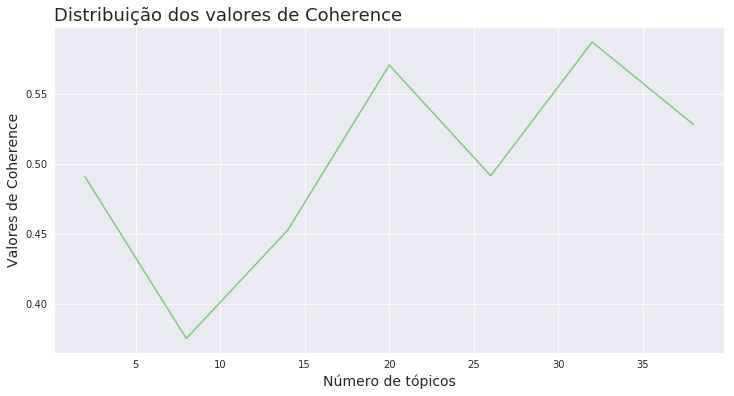

In [30]:
limit=40; start=2; step=6;
x = range(start, limit, step)

sns.set_palette('Accent')
sns.set_style('darkgrid')
ax = sns.lineplot(x, coherence_values)
ax.figure.set_size_inches(12,6)
ax.set_title("Distribuição dos valores de Coherence", loc='left', fontsize=18)
ax.set_xlabel("Número de tópicos", fontsize=14)
ax.set_ylabel("Valores de Coherence", fontsize=14)
ax = ax

In [32]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.491
Num Topics = 8  has Coherence Value of 0.3752
Num Topics = 14  has Coherence Value of 0.4528
Num Topics = 20  has Coherence Value of 0.5708
Num Topics = 26  has Coherence Value of 0.4916
Num Topics = 32  has Coherence Value of 0.5874
Num Topics = 38  has Coherence Value of 0.5283


In [33]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics())

[(0, '0.048*"plant" + 0.046*"sub_region" + 0.029*"second" + 0.025*"value" + 0.024*"seed" + 0.021*"invention" + 0.020*"hybrid" + 0.019*"part" + 0.018*"corn" + 0.018*"agronomic"'), (1, '0.006*"starch" + 0.005*"invention" + 0.004*"plant" + 0.003*"potato" + 0.003*"use" + 0.003*"crop" + 0.003*"produce" + 0.003*"store" + 0.003*"organ" + 0.003*"method"'), (2, '0.100*"acid" + 0.038*"form" + 0.038*"fatty" + 0.037*"soybean" + 0.034*"concentration" + 0.034*"endogenously" + 0.030*"palmitic" + 0.028*"oil" + 0.028*"stearic" + 0.025*"elevated"'), (3, '0.047*"soybean" + 0.041*"plant" + 0.029*"improve" + 0.025*"method" + 0.024*"provide" + 0.023*"corn" + 0.022*"grain" + 0.021*"content" + 0.021*"protein" + 0.020*"sequence"'), (4, '0.064*"plant" + 0.033*"seed" + 0.033*"cotton" + 0.020*"grow" + 0.017*"non" + 0.017*"male" + 0.017*"capable" + 0.016*"bee" + 0.014*"dehiscent" + 0.014*"sesame"'), (5, '0.074*"plant" + 0.041*"corn" + 0.023*"percent" + 0.021*"invention" + 0.021*"seed" + 0.020*"inbred" + 0.020*"inb

In [35]:
model_topics

[(13,
  [('maize', 0.0015595059),
   ('digestibility', 0.0015591254),
   ('relate', 0.0015582525),
   ('allele', 0.0015528991),
   ('use', 0.001547116),
   ('activity', 0.0015460033),
   ('due', 0.0015449043),
   ('reduced', 0.0015443948),
   ('delta', 0.0015443676),
   ('presence', 0.0015430434)]),
 (11,
  [('hybrid', 0.025537044),
   ('parent', 0.025058443),
   ('rice', 0.02337874),
   ('plant', 0.022804359),
   ('seed', 0.021421432),
   ('form', 0.017377414),
   ('basis', 0.014714163),
   ('possess', 0.014491354),
   ('generation', 0.014384044),
   ('flag', 0.01410113)]),
 (16,
  [('field', 0.047272395),
   ('include', 0.043090694),
   ('unit', 0.04153631),
   ('assembly', 0.03575747),
   ('engagement', 0.030366128),
   ('tool', 0.023572491),
   ('work', 0.023236059),
   ('additionally', 0.019421719),
   ('system', 0.016655205),
   ('program', 0.015594195)]),
 (1,
  [('starch', 0.0063823215),
   ('invention', 0.004848855),
   ('plant', 0.003590496),
   ('potato', 0.0033528383),
   (

In [41]:
optimal_model.print_topics()

[(0,
  '0.048*"plant" + 0.046*"sub_region" + 0.029*"second" + 0.025*"value" + 0.024*"seed" + 0.021*"invention" + 0.020*"hybrid" + 0.019*"part" + 0.018*"corn" + 0.018*"agronomic"'),
 (1,
  '0.006*"starch" + 0.005*"invention" + 0.004*"plant" + 0.003*"potato" + 0.003*"use" + 0.003*"crop" + 0.003*"produce" + 0.003*"store" + 0.003*"organ" + 0.003*"method"'),
 (2,
  '0.100*"acid" + 0.038*"form" + 0.038*"fatty" + 0.037*"soybean" + 0.034*"concentration" + 0.034*"endogenously" + 0.030*"palmitic" + 0.028*"oil" + 0.028*"stearic" + 0.025*"elevated"'),
 (3,
  '0.047*"soybean" + 0.041*"plant" + 0.029*"improve" + 0.025*"method" + 0.024*"provide" + 0.023*"corn" + 0.022*"grain" + 0.021*"content" + 0.021*"protein" + 0.020*"sequence"'),
 (4,
  '0.064*"plant" + 0.033*"seed" + 0.033*"cotton" + 0.020*"grow" + 0.017*"non" + 0.017*"male" + 0.017*"capable" + 0.016*"bee" + 0.014*"dehiscent" + 0.014*"sesame"'),
 (5,
  '0.074*"plant" + 0.041*"corn" + 0.023*"percent" + 0.021*"invention" + 0.021*"seed" + 0.020*"inb

In [46]:
optimal_model.get_topic_terms(0)

[(17, 0.048395418),
 (114, 0.04557113),
 (111, 0.029025346),
 (115, 0.024929108),
 (20, 0.024404315),
 (67, 0.021367555),
 (9, 0.020226477),
 (107, 0.018980114),
 (2, 0.018477488),
 (76, 0.018014716)]

In [51]:
c = dict()
for i in range(20):
    for a,b in optimal_model.get_topic_terms(i):
        
        if not a in c.keys():
            c[a] = 1
        else:
            c[a] += 1
        
        

In [53]:
len(c.keys())

119

In [36]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

SyntaxError: invalid syntax (<ipython-input-36-9e97abf0d495>, line 18)

In [37]:
# df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model,
#                                                   corpus=corpus, 
#                                                   texts=data_lemmatized)

In [38]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

NameError: name 'df_topic_sents_keywords' is not defined